<a href="https://colab.research.google.com/github/fadi-theodory/Prediction-of-Product-Sales/blob/main/_Project_1_Part_8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Project 1 - Part 8

In [1]:
from google.colab import drive
drive.mount('/content/drive')
# Import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('display.max_columns',100)
import missingno as msno
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
#classification imports
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, recall_score, precision_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import make_pipeline as make_sampler_pipeline
from sklearn.metrics import roc_auc_score, RocCurveDisplay
from sklearn.datasets import load_iris
from sklearn.inspection import permutation_importance

# setting random state for reproducibility
SEED = 321
np.random.seed(SEED)
plt.style.use(('ggplot','tableau-colorblind10'))

import joblib
import os
# Set pandas as the default output for sklearn
from sklearn import set_config
set_config(transform_output='pandas')



Mounted at /content/drive


In [2]:
# Define the custom functions for regressoin evaluation
def regression_metrics(y_true, y_pred, label='', verbose = True, output_dict=False):
  # Get metrics
  mae = mean_absolute_error(y_true, y_pred)
  mse = mean_squared_error(y_true, y_pred)
  rmse = np.sqrt(mse)
  r_squared = r2_score(y_true, y_pred)
  if verbose == True:
    # Print Result with Label and Header
    header = "-"*60
    print(header, f"Regression Metrics: {label}", header, sep='\n')
    print(f"- MAE = {mae:,.3f}")
    print(f"- MSE = {mse:,.3f}")
    print(f"- RMSE = {rmse:,.3f}")
    print(f"- R^2 = {r_squared:,.3f}")
  if output_dict == True:
      metrics = {'Label':label, 'MAE':mae,
                 'MSE':mse, 'RMSE':rmse, 'R^2':r_squared}
      return metrics

def evaluate_regression(reg, X_train, y_train, X_test, y_test, verbose = True,
                        output_frame=False):
  # Get predictions for training data
  y_train_pred = reg.predict(X_train)

  # Call the helper function to obtain regression metrics for training data
  results_train = regression_metrics(y_train, y_train_pred, verbose = verbose,
                                     output_dict=output_frame,
                                     label='Training Data')
  print()
  # Get predictions for test data
  y_test_pred = reg.predict(X_test)
  # Call the helper function to obtain regression metrics for test data
  results_test = regression_metrics(y_test, y_test_pred, verbose = verbose,
                                  output_dict=output_frame,
                                    label='Test Data' )

  # Store results in a dataframe if ouput_frame is True
  if output_frame:
    results_df = pd.DataFrame([results_train,results_test])
    # Set the label as the index
    results_df = results_df.set_index('Label')
    # Set index.name to none to get a cleaner looking result
    results_df.index.name=None
    # Return the dataframe
    return results_df.round(3)

In [3]:
# to read the data
fpath="/content/drive/MyDrive/AXSOSACADEMY/02-IntroML/Week05/Data/sales_predictions_2023.csv"
df=pd.read_csv(fpath)
df.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   object 
 1   Item_Weight                7060 non-null   float64
 2   Item_Fat_Content           8523 non-null   object 
 3   Item_Visibility            8523 non-null   float64
 4   Item_Type                  8523 non-null   object 
 5   Item_MRP                   8523 non-null   float64
 6   Outlet_Identifier          8523 non-null   object 
 7   Outlet_Establishment_Year  8523 non-null   int64  
 8   Outlet_Size                6113 non-null   object 
 9   Outlet_Location_Type       8523 non-null   object 
 10  Outlet_Type                8523 non-null   object 
 11  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.2+ KB


check duplicates

In [5]:
# to check duplicates
df.duplicated().sum()

np.int64(0)

to drop the item_identifier

In [6]:
# drop Item_Identifier
df=df.drop(columns='Item_Identifier')

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 11 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Weight                7060 non-null   float64
 1   Item_Fat_Content           8523 non-null   object 
 2   Item_Visibility            8523 non-null   float64
 3   Item_Type                  8523 non-null   object 
 4   Item_MRP                   8523 non-null   float64
 5   Outlet_Identifier          8523 non-null   object 
 6   Outlet_Establishment_Year  8523 non-null   int64  
 7   Outlet_Size                6113 non-null   object 
 8   Outlet_Location_Type       8523 non-null   object 
 9   Outlet_Type                8523 non-null   object 
 10  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(6)
memory usage: 732.6+ KB


to check inconsistencies in cat data

In [8]:
#define cat_columns
cat_cols=df.select_dtypes(include='object').columns
cat_cols

Index(['Item_Fat_Content', 'Item_Type', 'Outlet_Identifier', 'Outlet_Size',
       'Outlet_Location_Type', 'Outlet_Type'],
      dtype='object')

In [9]:
# make a for loop that counts the cat_cols
for col in cat_cols:
  count=df[col].value_counts()
  print(f"{col} has the following values {count}")
  # to make a line between each result

  print("\n")

Item_Fat_Content has the following values Item_Fat_Content
Low Fat    5089
Regular    2889
LF          316
reg         117
low fat     112
Name: count, dtype: int64


Item_Type has the following values Item_Type
Fruits and Vegetables    1232
Snack Foods              1200
Household                 910
Frozen Foods              856
Dairy                     682
Canned                    649
Baking Goods              648
Health and Hygiene        520
Soft Drinks               445
Meat                      425
Breads                    251
Hard Drinks               214
Others                    169
Starchy Foods             148
Breakfast                 110
Seafood                    64
Name: count, dtype: int64


Outlet_Identifier has the following values Outlet_Identifier
OUT027    935
OUT013    932
OUT035    930
OUT049    930
OUT046    930
OUT045    929
OUT018    928
OUT017    926
OUT010    555
OUT019    528
Name: count, dtype: int64


Outlet_Size has the following values Outlet_Size
Me

In [10]:
# Item_Fat_Content has inconsistent data
df['Item_Fat_Content'].value_counts()

,count
Item_Fat_Content,
Low Fat,5089
Regular,2889
LF,316
reg,117
low fat,112


In [11]:
# to replace LF to Low Fat, reg to Regular and low fat to Low Fat
df['Item_Fat_Content']=df['Item_Fat_Content'].replace({'LF':'Low Fat','reg':'Regular','low fat':'Low Fat'})
df['Item_Fat_Content'].value_counts()

,count
Item_Fat_Content,
Low Fat,5517
Regular,3006


to check the reasonability of numbers

In [12]:

num_cols=df.select_dtypes(include="number")
num_cols.head()

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Outlet_Sales
0,9.30,0.016047,249.8092,1999,3735.1380
1,5.92,0.019278,48.2692,2009,443.4228
2,17.50,0.016760,141.6180,1999,2097.2700
3,19.20,0.000000,182.0950,1998,732.3800
4,8.93,0.000000,53.8614,1987,994.7052


In [13]:

for x in num_cols:
  print(x)
  print(num_cols[x].describe())
  print("\n")

Item_Weight
count    7060.000000
mean       12.857645
std         4.643456
min         4.555000
25%         8.773750
50%        12.600000
75%        16.850000
max        21.350000
Name: Item_Weight, dtype: float64


Item_Visibility
count    8523.000000
mean        0.066132
std         0.051598
min         0.000000
25%         0.026989
50%         0.053931
75%         0.094585
max         0.328391
Name: Item_Visibility, dtype: float64


Item_MRP
count    8523.000000
mean      140.992782
std        62.275067
min        31.290000
25%        93.826500
50%       143.012800
75%       185.643700
max       266.888400
Name: Item_MRP, dtype: float64


Outlet_Establishment_Year
count    8523.000000
mean     1997.831867
std         8.371760
min      1985.000000
25%      1987.000000
50%      1999.000000
75%      2004.000000
max      2009.000000
Name: Outlet_Establishment_Year, dtype: float64


Item_Outlet_Sales
count     8523.000000
mean      2181.288914
std       1706.499616
min         33.290000


**Prepare for ML**

## Train test split

In [14]:
# To define x and y so we split
X=df.drop(columns='Item_Outlet_Sales')
y=df['Item_Outlet_Sales']
y.head()

,Item_Outlet_Sales
0,3735.1380
1,443.4228
2,2097.2700
3,732.3800
4,994.7052


In [37]:
#to split x and y into train and test
X_train,X_test,y_train,y_test=train_test_split(X,y,random_state=SEED)

## Create Pipelines and Define Tuples

### PREPROCESSING Data

In [38]:
# select numeric cols
cat_cols = make_column_selector(dtype_include='object')

# make numeric pipeline
cat_pipe = make_pipeline(SimpleImputer(strategy='constant',
                                       fill_value='MISSING'),
                         OneHotEncoder(drop = 'if_binary', sparse_output=False))
# cat_tuple
cat_tuple = ('categorical', cat_pipe, cat_cols)

# select numeric cols
num_cols = make_column_selector(dtype_include='number')

# make numeric pipeline
num_pipe = make_pipeline(SimpleImputer(strategy='mean'))

# numeric tuple
num_tuple =('numeric', num_pipe, num_cols)

# Create the Column Transformer
preprocessor = ColumnTransformer([num_tuple, cat_tuple], verbose_feature_names_out=False)
preprocessor


ColumnTransformer(transformers=[('numeric',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer())]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7a897f4f9d90>),
                                ('categorical',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(fill_value='MISSING',
                                                                strategy='constant')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(drop='if_binary',
                                                                sparse_output=False))]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7a897f4f85d0>)],
                  verbose_feature_names_out=False)

## Fit the Transformer on Training Data

In [40]:
## fit column transformer and run get_feature_names_out
preprocessor.fit(X_train)
feature_names = preprocessor.get_feature_names_out()

X_train_tf = pd.DataFrame(preprocessor.transform(X_train),
                          columns = feature_names, index = X_train.index)

X_test_tf = pd.DataFrame(preprocessor.transform(X_test),
                          columns = feature_names, index = X_test.index)
X_test_tf.head(3)


,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Fat_Content_Regular,Item_Type_Baking Goods,Item_Type_Breads,Item_Type_Breakfast,Item_Type_Canned,Item_Type_Dairy,Item_Type_Frozen Foods,Item_Type_Fruits and Vegetables,Item_Type_Hard Drinks,Item_Type_Health and Hygiene,Item_Type_Household,Item_Type_Meat,Item_Type_Others,Item_Type_Seafood,Item_Type_Snack Foods,Item_Type_Soft Drinks,Item_Type_Starchy Foods,Outlet_Identifier_OUT010,Outlet_Identifier_OUT013,Outlet_Identifier_OUT017,Outlet_Identifier_OUT018,Outlet_Identifier_OUT019,Outlet_Identifier_OUT027,Outlet_Identifier_OUT035,Outlet_Identifier_OUT045,Outlet_Identifier_OUT046,Outlet_Identifier_OUT049,Outlet_Size_High,Outlet_Size_MISSING,Outlet_Size_Medium,Outlet_Size_Small,Outlet_Location_Type_Tier 1,Outlet_Location_Type_Tier 2,Outlet_Location_Type_Tier 3,Outlet_Type_Grocery Store,Outlet_Type_Supermarket Type1,Outlet_Type_Supermarket Type2,Outlet_Type_Supermarket Type3
8077,15.25,0.061531,132.2968,2007.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
2391,17.85,0.044463,127.1020,1997.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
163,7.27,0.071078,114.2518,1997.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0


## Linear Regression

### 1. Extract and visualize the coefficients determined by your model.


In [41]:
lin_reg = LinearRegression()
lin_reg.fit(X_train_tf,y_train)
evaluate_regression(lin_reg, X_train_tf, y_train, X_test_tf,y_test)


------------------------------------------------------------
Regression Metrics: Training Data
------------------------------------------------------------
- MAE = 826.786
- MSE = 1,243,176.489
- RMSE = 1,114.978
- R^2 = 0.564

------------------------------------------------------------
Regression Metrics: Test Data
------------------------------------------------------------
- MAE = 859.971
- MSE = 1,355,858.314
- RMSE = 1,164.413
- R^2 = 0.560


In [42]:
def plot_coeffs(coeffs, top_n=None,  figsize=(4,5), intercept=False,
                annotate=False, ha='left',va='center', size=12, xytext=(4,0),
                  textcoords='offset points'):
    """Plots the top_n coefficients from a Series, with optional annotations."""
    if (intercept==False) & ('intercept' in coeffs.index):
        coeffs = coeffs.drop('intercept')
    if top_n==None:
        ## sort all features and set title
        plot_vals = coeffs#.sort_values()
        title = "All Coefficients - Ranked by Magnitude"
    else:
        ## rank the coeffs and select the top_n
        coeff_rank = coeffs.abs().rank().sort_values(ascending=False)
        top_n_features = coeff_rank.head(top_n)
        plot_vals = coeffs.loc[top_n_features.index].sort_values()
        ## sort features and keep top_n and set title
        title = f"Top {top_n} Largest Coefficients"
    ## plotting top N importances
    ax = plot_vals.plot(kind='barh', figsize=figsize)
    ax.set(xlabel='Coefficient',
           ylabel='Feature Names',
           title=title)
    ax.axvline(0, color='k')

    if annotate==True:
        annotate_hbars(ax, ha=ha,va=va,size=size,xytext=xytext,
                       textcoords=textcoords)
    ## return ax in case want to continue to update/modify figure
    return ax

def annotate_hbars(ax, ha='left',va='center',size=12,  xytext=(4,0),
                  textcoords='offset points'):
    for bar in ax.patches:

        ## calculate center of bar
        bar_ax = bar.get_y() + bar.get_height()/2
        ## get the value to annotate
        val = bar.get_width()
        if val < 0:
            val_pos = 0
        else:
            val_pos = val
        # ha and va stand for the horizontal and vertical alignment
        ax.annotate(f"{val:.3f}", (val_pos,bar_ax), ha=ha,va=va,size=size,
                        xytext=xytext, textcoords=textcoords)


In [44]:
coeffs = pd.Series(lin_reg.coef_, index=feature_names,
                        name='Coefficients')
coeffs.loc['intercept'] = lin_reg.intercept_
coeffs.head()


,Coefficients
Item_Weight,1.067856
Item_Visibility,-276.611557
Item_MRP,15.601944
Outlet_Establishment_Year,-14.220421
Item_Fat_Content_Regular,31.376589


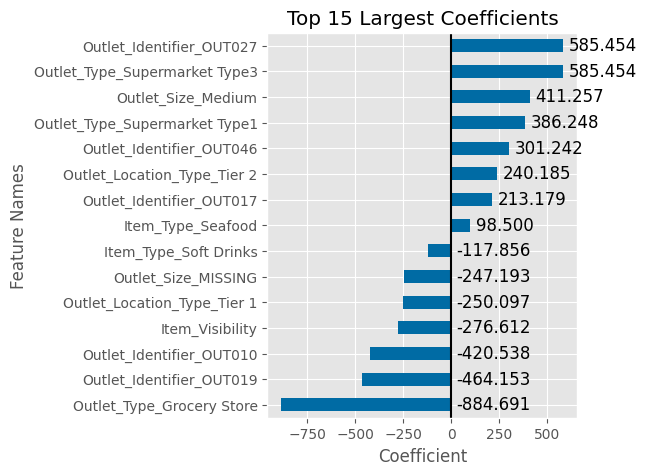

In [45]:
plot_coeffs(coeffs,top_n=15,intercept=False,annotate=True);

### 2. Identify the top 3 most impactful features and explain their coefficients in simple language.

the top impactful features are


1.  Outlet Identifier- out27. product sold in the outlet 27 increases  the sales increase by `585`.

1.   OUTLET TYPE supermarket type 3 same as before
2.   Outlet type grocery store. for items sold in outlet type grocery store, the saes will decrease by `884.691`





##Tree-Based Model


In [46]:
reg = RandomForestRegressor()
reg.fit(X_train_tf,y_train)
evaluate_regression(reg, X_train_tf, y_train, X_test_tf,y_test)


------------------------------------------------------------
Regression Metrics: Training Data
------------------------------------------------------------
- MAE = 292.556
- MSE = 179,488.498
- RMSE = 423.661
- R^2 = 0.937

------------------------------------------------------------
Regression Metrics: Test Data
------------------------------------------------------------
- MAE = 815.356
- MSE = 1,353,886.830
- RMSE = 1,163.566
- R^2 = 0.561


> the model is overfitting here, but we will pass this. we will not perform tuning here

In [47]:
feature_importance = pd.Series(reg.feature_importances_, index=feature_names,
                        name='Feature Importances')
feature_importance.head()


,Feature Importances
Item_Weight,0.053850
Item_Visibility,0.097620
Item_MRP,0.444090
Outlet_Establishment_Year,0.024433
Item_Fat_Content_Regular,0.008420


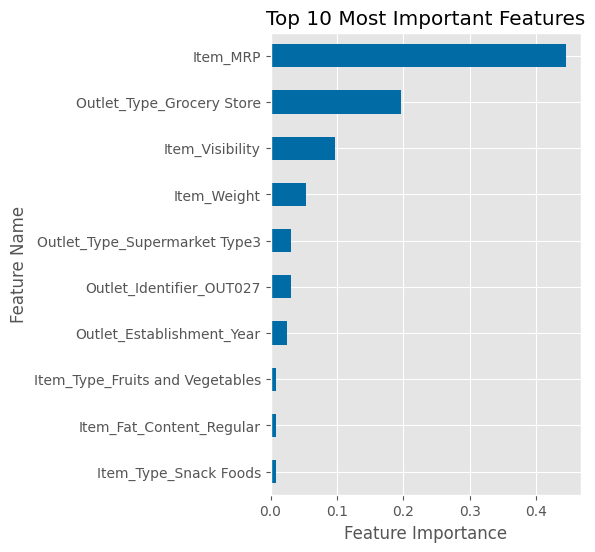

In [48]:
ax = feature_importance.sort_values().tail(10).plot(kind='barh',figsize=(4,6))
ax.set(ylabel='Feature Name',xlabel='Feature Importance',
       title='Top 10 Most Important Features');


The most important 5 features are:



1.   Item MRP
2.   Outlet type grocery store
3.   Item Visibility
4. Item weight
5. outlet Type supermarket 3

